In [41]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [48]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [49]:
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_dim):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2048, output_dim),
            nn.Tanh()
        )
        self.apply(init_weights)

    def forward(self, noise, labels):
        labels = self.label_emb(labels)
        gen_input = torch.cat((noise, labels), dim=1)
        return self.model(gen_input)

In [50]:
class Critic(nn.Module):
    def __init__(self, input_dim, label_dim):
        super(Critic, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)  
        self.model = nn.Sequential(
            nn.Linear(input_dim + label_dim, 512),  
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
        self.apply(init_weights)

    def forward(self, inputs, labels):
        labels = self.label_emb(labels).view(labels.size(0), -1)
        disc_input = torch.cat((inputs, labels), dim=1)
        return self.model(disc_input)

In [44]:
def gradient_penalty(C, real_samples, fake_samples, real_labels, lambda_gp):
    """Calculates the gradient penalty loss for WGAN GP"""
    alpha = torch.rand(real_samples.size(0), 1, device=real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    interpolated_labels = real_labels.view(real_labels.size(0), -1)
    d_interpolates = C(interpolates, interpolated_labels)
    
    fake = torch.ones(d_interpolates.size(), device=real_samples.device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates, inputs=interpolates,
        grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

In [51]:
# def generate_csi_samples(generator, label_dim, noise_dim, num_samples, device):
#     generator.eval()
#     noise = torch.randn(num_samples, noise_dim).to(device)
#     labels = torch.randint(0, label_dim, (num_samples,)).to(device)

#     with torch.no_grad():
#         synthetic_data = generator(noise, labels).cpu()
#     return synthetic_data, labels.cpu()

def generate_csi_samples(generator, label_dim, noise_dim, num_samples, device):
    generator.eval()
    noise = torch.randn(num_samples, noise_dim).to(device)
    labels = torch.randint(0, label_dim, (num_samples,)).to(device)
    
    with torch.no_grad():
        synthetic_data = generator(noise, labels)
    return synthetic_data, labels

In [55]:
def train_gan(data, labels, epochs=50, batch_size=32, noise_dim=100, lr_g=0.00005, lr_c=0.00005, lambda_gp=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = data.float()
    labels = labels.long()
    dataset = TensorDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    G = Generator(noise_dim, 8, data.shape[1] * data.shape[2]).to(device)
    C = Critic(data.shape[1] * data.shape[2], 8).to(device)

    optimizer_g = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_c = optim.Adam(C.parameters(), lr=lr_c, betas=(0.5, 0.999))

    critic_losses = []
    generator_losses = []

    for epoch in range(epochs):
        epoch_critic_loss = 0.0
        epoch_generator_loss = 0.0
        for i, (real_data, real_labels) in enumerate(dataloader):
            real_data = real_data.to(device).view(-1, data.shape[1] * data.shape[2])
            real_labels = real_labels.to(device)

            batch_size = real_data.size(0)
            noise = torch.randn(batch_size, noise_dim).to(device)
            fake_labels = torch.randint(0, 8, (batch_size,)).to(device)
            fake_data = G(noise, fake_labels)

            real_targets = torch.ones(batch_size, 1).to(device)
            fake_targets = torch.zeros(batch_size, 1).to(device)

            # Train Critic
            optimizer_c.zero_grad()
            real_output = C(real_data, real_labels)
            fake_output = C(fake_data.detach(), fake_labels)
            gp = gradient_penalty(C, real_data, fake_data, real_labels, lambda_gp)
            loss_c = -torch.mean(real_output) + torch.mean(fake_output) + gp
            loss_c.backward(retain_graph=True)
            optimizer_c.step()
            epoch_critic_loss += loss_c.item()

            # Train Generator every 5 iterations of Critic
            if i % 5 == 0:
                optimizer_g.zero_grad()
                fake_output = C(fake_data, fake_labels)
                loss_g = -torch.mean(fake_output)
                loss_g.backward(retain_graph=True)
                optimizer_g.step()
                epoch_generator_loss += loss_g.item()

        critic_losses.append(epoch_critic_loss / len(dataloader))
        generator_losses.append(epoch_generator_loss / (len(dataloader) // 5))
        
        # if (epoch + 1) % 500 == 0:
        #     synthetic_csi, _ = generate_csi_samples(G, 8, noise_dim, num_samples=200, device=device)
        #     torch.save(synthetic_csi, f'csi_data_epoch_{epoch + 1}.pth')
        if (epoch + 1) % 20 == 0:
            synthetic_csi, syn_labels = generate_csi_samples(G, 8, noise_dim, 500, device=device)
            torch.save({'synthetic_csi': synthetic_csi, 'labels': syn_labels}, f'csi_data_epoch_{epoch + 1}.pth')

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Critic Loss: {critic_losses[-1]:.4f}, Generator Loss: {generator_losses[-1]:.4f}')
            torch.save(G.state_dict(), f'generator_{epoch + 1}.pth')

    return G, C, critic_losses, generator_losses

C:\Users\dgm82\AppData\Local\Temp\ipykernel_11844\1495048577.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_user1 = torch.load('data_mm_user1.pth')
C:\Users\dgm82\

Epoch [20/50], Critic Loss: -41.3905, Generator Loss: 2.7807
Epoch [40/50], Critic Loss: -37.9323, Generator Loss: -5.9144


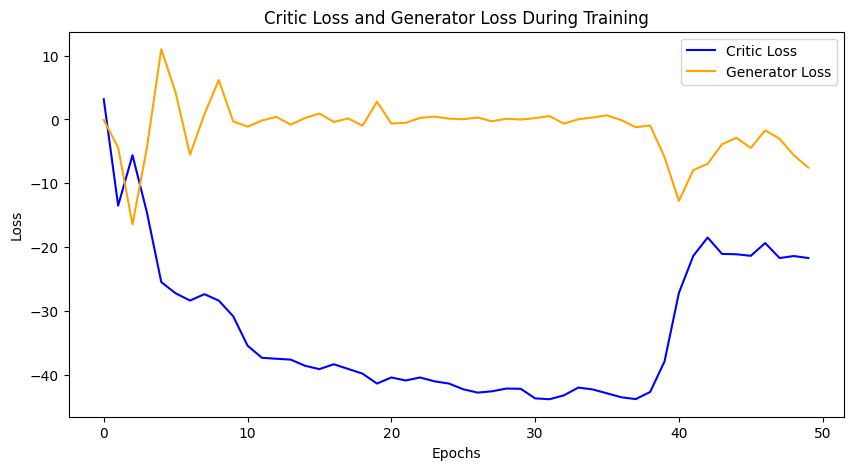

In [56]:
data_user1 = torch.load('data_mm_user1.pth')  
labels_user1 = torch.load('labels_user1.pth')  

data_user1 = (data_user1 - data_user1.min()) / (data_user1.max() - data_user1.min())  # Normalize data between 0 and 1
data_user1 = (data_user1 - data_user1.mean()) / data_user1.std()  # Standardize data

G, C, critic_losses, generator_losses = train_gan(data_user1, labels_user1)

plt.figure(figsize=(10, 5))
plt.plot(critic_losses, label='Critic Loss', color='blue')
plt.plot(generator_losses, label='Generator Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Critic Loss and Generator Loss During Training')
plt.show()

In [8]:
# def gradient_penalty(C, real_data, fake_data, real_labels, lambda_gp):
#     batch_size = real_data.size(0)
#     epsilon = torch.rand(batch_size, 1, device=real_data.device)
#     epsilon = epsilon.expand(real_data.size())
#     interpolates = epsilon * real_data + ((1 - epsilon) * fake_data)
#     interpolates.requires_grad_(True)

#     # Forward pass of interpolates through the critic
#     interpolated_labels = real_labels.view(batch_size, -1)
#     d_interpolates = C(interpolates, interpolated_labels)

#     # Create ones tensor for gradient calculation
#     fake = torch.ones(d_interpolates.size(), device=real_data.device)

#     # Calculate gradients of interpolates with respect to critic's prediction
#     gradients = torch.autograd.grad(
#         outputs=d_interpolates, inputs=interpolates,
#         grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True
#     )[0]

#     gradients = gradients.view(gradients.size(0), -1)
#     gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
#     return gradient_penalty

In [10]:
# def train_gan(data, labels, epochs=300, batch_size=32, noise_dim=100, lr_g=1e-4, lr_c=1e-5, lambda_gp=10):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     data = data.float()
#     labels = labels.long()
#     dataset = TensorDataset(data, labels)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#     G = Generator(noise_dim, 8, data.shape[1] * data.shape[2]).to(device)
#     C = Critic(data.shape[1] * data.shape[2], 8).to(device)

#     optimizer_g = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))
#     optimizer_c = optim.Adam(C.parameters(), lr=lr_c, betas=(0.5, 0.999))

#     critic_losses = []
#     generator_losses = []

#     for epoch in range(epochs):
#         for i, (real_data, real_labels) in enumerate(dataloader):
#             real_data = real_data.to(device).view(-1, data.shape[1] * data.shape[2])
#             real_labels = real_labels.to(device)

#             batch_size = real_data.size(0)
#             noise = torch.randn(batch_size, noise_dim).to(device)
#             fake_labels = torch.randint(0, 8, (batch_size,)).to(device)
#             fake_data = G(noise, fake_labels)

#             real_targets = torch.ones(batch_size, 1).to(device)
#             fake_targets = torch.zeros(batch_size, 1).to(device)

#             # Train Critic
#             optimizer_c.zero_grad()
#             real_output = C(real_data, real_labels)
#             fake_output = C(fake_data.detach(), fake_labels)
#             gp = gradient_penalty(C, real_data, fake_data, real_labels, lambda_gp)
#             loss_c = -torch.mean(real_output) + torch.mean(fake_output) + gp
#             loss_c.backward(retain_graph=True)
#             optimizer_c.step()
#             critic_losses.append(loss_c.item())

#             # Train Generator every 5 iterations of Critic
#             if i % 5 == 0:
#                 optimizer_g.zero_grad()
#                 fake_output = C(fake_data, fake_labels)
#                 loss_g = -torch.mean(fake_output)
#                 loss_g.backward(retain_graph=True)
#                 optimizer_g.step()
#                 generator_losses.append(loss_g.item())

#         if (epoch + 1) % 1000 == 0:
#             print(f'Epoch [{epoch + 1}/{epochs}], Critic Loss: {loss_c.item():.4f}, Generator Loss: {loss_g.item():.4f}')
#             torch.save(G.state_dict(), f'generator_{epoch + 1}.pth')

#     return G, C, critic_losses, generator_losses


In [5]:
# # Load your data and labels from .pth files
# data_user1 = torch.load('data_mm_user1.pth')  # replace with the actual path to your .pth file
# labels_user1 = torch.load('labels_user1.pth')  # replace with the actual path to your .pth file

# G, C, critic_losses, generator_losses = train_gan(data_user1, labels_user1)

# # Plotting the losses
# plt.figure(figsize=(10, 5))
# plt.plot(critic_losses, label='Critic Loss')
# plt.plot(generator_losses, label='Generator Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Critic Loss and Generator Loss During Training')
# plt.show()